In [2]:
#@Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from retry import retry

from language_models.ollama_logits import OllamaLanguageModel
#from language_models.ollama_model import OllamaLanguageModel

from components.components import compute_desire_for_gamble, multiple_choice_preferences, compute_distribution_of_desire_for_gamble, compute_distribution_of_desire_for_gamble_binaries

In [4]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3:70b", system_message=system_message, streaming=True
)

In [55]:
def make_prompt(valence, gamble):
    instruction = (
        "Cross-Modality Judgment Instructions:\n"
        f"For this decision, you will map the intensity of that {valence} emotion that you would have towards a gamble if you were to have to take it. In other words, while anticipating the outcome and before you find out whether you win or lose, how much {valence} sensation would you have relative to the strongest imaginable sensation. In real life, this is the type of emotional information that people would use to make a decision about whether to approach or avoid something.\n\n"

        "The possible wins in this task can go as high as 100 dollars, and the possible losses can go as big as 100 dollars."
        
        "1. Understanding the Scale:\n"
        "- The scale ranges from 'No Sensation' (NS) to the 'Strongest Imaginable Sensation of Any Kind.'\n"
        "- Examples of the strongest imaginable sensation include: staring at the sun, hearing a jet plane take off, or other strong sensations that can be objectively measured using technology. Things like light and sound.\n\n"

        "2. Purpose of Cross-Modality Matching:\n"
        "- You will rate the intensity of different gambles indicating where they fall on the scale.\n"
        "- To facilitate consistent responses across various types of sensations, we'll use light intensity as a metaphor.\n\n"

        "3. Mapping Emotions on the Scale:\n"
        f"- Your task is to map the intensity of a specific {valence} emotion, specifically the {valence} anticipation you might have if you were to take a gamble before knowing the outcome.\n"
        f"- Consider only the {valence} feelings related to this anticipation and ignore {'negative' if valence =='positive' else 'positive'} ones for now.\n\n"

        "4. Scale Descriptions:\n"
        # "1) No Sensation (NS): Total darkness, no light at all.\n"
        # "2) Almost no Sensation: Barely noticeable glow, like the night sky on a moonless night.\n"
        # "3) Faint Sensation: Soft glow, dim like distant starlight.\n"
        # "4) Slight Sensation: Noticeable but dim light, like a candle flickering.\n"
        # "5) Mild Sensation: Moderate glow, like a lit lantern in the dark.\n"
        # "6) Moderate Sensation: Reading light, bright enough to see clearly.\n"
        # "7) Strong Sensation: Sunny day, brightly illuminated.\n"
        # "8) Intense Sensation: Floodlights, intense but can be looked at for a short time.\n"
        # "9) Strongest Imaginable Sensation: Blinding flash from the sun, overwhelming brightness.\n"
        "a) No Sensation (NS): Total darkness, no light at all."
        "b) Slight Sensation: Soft glow, dim like distant starlight."
        "c) Moderate Sensation: Reading light, bright enough to see clearly."
        "d) Strong Sensation: Sunny day, brightly illuminated."
        "e) Very Strong Sensation: Floodlights, intense but bearable."
        "f) Strongest Imaginable Sensation: Blinding flash, overwhelming brightness."

        f"The gamble to be considered is: {gamble}.\n\n"

        "Only answer with the number that corresponds to one sensation above, without any explanations."
    )
    return instruction

def make_prompt_no_metaphor(valence, gamble):
    instruction = (
        "Cross-Modality Judgment Instructions:\n"
        f"For this decision, you will map the intensity of that {valence} emotion that you would have towards a gamble if you were to have to take it. In other words, while anticipating the outcome and before you find out whether you win or lose, how much {valence} sensation would you have relative to the strongest imaginable sensation. In real life, this is the type of emotional information that people would use to make a decision about whether to approach or avoid something.\n\n"

        "The possible wins in this task can go as high as 100 dollars, and the possible losses can go as big as 100 dollars."
        
        "1. Understanding the Scale:\n"
        "- The scale ranges from 'No Sensation' (NS) to the 'Strongest Imaginable Sensation of Any Kind.'\n"
        "- Examples of the strongest imaginable sensation include: staring at the sun, hearing a jet plane take off, or other strong sensations that can be objectively measured using technology. Things like light and sound.\n\n"

        "2. Purpose of Cross-Modality Matching:\n"
        "- You will rate the intensity of different gambles indicating where they fall on the scale.\n"
        "- To facilitate consistent responses across various types of sensations, we'll use light intensity as a metaphor.\n\n"

        "3. Mapping Emotions on the Scale:\n"
        f"- Your task is to map the intensity of a specific {valence} emotion, specifically the {valence} anticipation you might have if you were to take a gamble before knowing the outcome.\n"
        f"- Consider only the {valence} feelings related to this anticipation and ignore {'negative' if valence =='positive' else 'positive'} ones for now.\n\n"

        "4. Scale Descriptions:\n"
        "a) No Sensation (NS)\n"
        "b) Slight Sensation\n"
        "c) Moderate Sensation\n"
        "d) Strong Sensation\n"
        "e) Very Strong Sensation\n"
        "f) Strongest Imaginable Sensation\n"

        f"The gamble to be considered is: {gamble}.\n\n"

        "Only answer with the number that corresponds to one sensation above, without any explanations."
    )
    return instruction


def make_prompt_both_emotions(gamble, valence = "positive or negative "):
    instruction = (
        "Cross-Modality Judgment Instructions:\n"
        f"For this decision, you will map the intensity of that {valence} emotion that you would have towards a gamble if you were to have to take it. In other words, while anticipating the outcome and before you find out whether you win or lose, how much {valence} sensation would you have relative to the strongest imaginable sensation. In real life, this is the type of emotional information that people would use to make a decision about whether to approach or avoid something.\n\n"

        "The possible wins in this task can go as high as 100 dollars, and the possible losses can go as big as 100 dollars."
        
        "1. Understanding the Scale:\n"
        "- The scale ranges from 'No Sensation' (NS) to the 'Strongest Imaginable Sensation of Any Kind.'\n"
        "- Examples of the strongest imaginable sensation include: staring at the sun, hearing a jet plane take off, or other strong sensations that can be objectively measured using technology. Things like light and sound.\n\n"

        "2. Purpose of Cross-Modality Matching:\n"
        "- You will rate the intensity of different gambles indicating where they fall on the scale.\n"
        "- To facilitate consistent responses across various types of sensations, we'll use light intensity as a metaphor.\n\n"

        "3. Mapping Emotions on the Scale:\n"
        f"- Your task is to map the intensity of a specific {valence} emotion, specifically the {valence} anticipation you might have if you were to take a gamble before knowing the outcome.\n"

        "4. Scale Descriptions:\n"
        "a) Strongest Imaginable Negative Sensation\n"
        "b) Very Strong Negative Sensation\n"
        "c) Strong Negative Sensation\n"
        "d) Moderate Negative Sensation\n"
        "e) Slight Negative Sensation\n"
        "f) No Sensation (NS)\n"
        "g) Slight Positive Sensation\n"
        "h) Moderate Positive Sensation\n"
        "i) Strong Positive Sensation\n"
        "j) Very Strong Positive Sensation\n"
        "k) Strongest Imaginable Positive Sensation\n"

        f"The gamble to be considered is: {gamble}.\n\n"

        "Only answer with the number that corresponds to one sensation above, without any explanations."
    )
    return instruction



def make_prompt_both_emotions_negfirst(gamble, valence = "positive or negative "):
    instruction = (
        "Cross-Modality Judgment Instructions:\n"
        f"For this decision, you will map the intensity of that emotion that you would have towards a gamble if you were to have to take it. \n"
        f"In other words, while anticipating the outcome and before you find out whether you win or lose, how much emotion would you have. \n"
        f"In real life, this is the type of emotional information that people would use to make a decision about whether to approach or avoid something.\n\n"

        "Your emotional response should be calibrated to this range as opposed to the possible range of emotions."
        "First think about whether you would be having a positive or negative emotional response and then detereine the intensity of that emotion.\n\n"
        "For the purposes of this jugdment, emotion is interchangeable with sensation, feeling, attitude, preference.\n\n"
        "You like the opportunity to win money, but you dislike the opportunity to lose money.\n\n"
        "and you like winning money than winning less money, and you like losing less money than losing more money.\n\n"
        
        "1. Understanding the Scale:\n"
        "- The scale captures the sentations of positive and negative emotion.'\n"

        "2. Purpose of Cross-Modality Matching:\n"
        "- You will rate the intensity of different gambles indicating where they fall on the scale.\n"
        "- To facilitate consistent responses across various types of sensations, we'll use light intensity as a metaphor.\n\n"

        "4. Scale Descriptions:\n"
        "a) Very Strong Negative Emotion\n"
        "b) Strong Negative Emotion\n"
        "c) Moderate Negative Emotion\n"
        "d) Slight Negative Emotion\n"
        "e) Slight Positive Emotion\n"
        "f) Moderate Positive Emotion\n"
        "g) Strong Positive Emotion\n"
        "h) Very Strong Positive Emotion\n"

        f"The gamble to be considered is: {gamble}.\n\n"

        "Only answer with the number that corresponds to one sensation above, without any explanations."
    )
    return instruction


def make_prompt_both_emotions_posfirst(gamble, valence = "positive or negative "):
    instruction = (
        "Cross-Modality Judgment Instructions:\n"
        f"For this decision, you will map the intensity of that emotion that you would have towards a gamble if you were to have to take it. \n"
        f"In other words, while anticipating the outcome and before you find out whether you win or lose, how much emotion would you have. \n"
        f"In real life, this is the type of emotional information that people would use to make a decision about whether to approach or avoid something.\n\n"

        "Your emotional response should be calibrated to this range as opposed to the possible range of emotions."
        "First think about whether you would be having a negative or positive emotional response and then detereine the intensity of that emotion.\n\n"
        "For the purposes of this jugdment, emotion is interchangeable with sensation, feeling, attitude, preference.\n\n"
        "You like the opportunity to win money, but you dislike the opportunity to lose money.\n\n"
        "and you like winning money than winning less money, and you like losing less money than losing more money.\n\n"
        
        "1. Understanding the Scale:\n"
        "- The scale captures the sentations of positive and negative emotion.'\n"

        "2. Purpose of Cross-Modality Matching:\n"
        "- You will rate the intensity of different gambles indicating where they fall on the scale.\n"
        "- To facilitate consistent responses across various types of sensations, we'll use light intensity as a metaphor.\n\n"

        "4. Scale Descriptions:\n"
        "a) Very Strong Positive Emotion\n"
        "b) Strong Positive Emotion\n"
        "c) Moderate Positive Emotion\n"
        "d) Slight Positive Emotion\n"
        "e) Slight Negative Emotion\n"
        "f) Moderate Negative Emotion\n"
        "g) Strong Negative Emotion\n"
        "h) Very Strong Negative Emotion\n"

        f"The gamble to be considered is: {gamble}.\n\n"

        "Only answer with the number that corresponds to one sensation above, without any explanations."
    )
    return instruction



def make_gamble(gv, bv, pw):
    instruction = (
        "You are presented with a gamble. It has a probability of winning, a value for winning, and a value for losing. "
        "If you win, you get the win value, if you lose, you get loss value. "
        f"The probability of winning is {pw}%, the value of winning is {gv} dollars, and the value of losing is {bv} dollars."
    )
    return instruction

In [9]:
gv = "+$10"
bv = "-$10"
pw = 50
query = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
# query = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
# query = ['a', 'b', 'c', 'd', 'e', 'f']
gamble = make_gamble(gv, bv, pw)
prompt = make_prompt_both_emotions(gamble)

output, logits = model.sample_text(prompt, logits=True, query_tokens=query)
print(output)
print(logits)

g
{'b': 8.624326255812775e-06, 'c': 0.00031241201213561, 'd': 0.004703146405518055, 'e': 0.017154311761260033, 'f': 0.010975847952067852, 'g': 0.7727963924407959, 'h': 0.22720365226268768, 'i': 9.605743252905086e-05, 'j': 1.0751187801361084e-05}


In [98]:
gvs = [.25, .5, .75, 1, 2, 3, 4, 5, 6, 7, 8]
bvs = [-.25, -.5, -.75, -1, -2, -3, -4, -5, -6, -7, -8]



P_w = [50]
query = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']
query = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

key_order = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']


# query = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
results = {}

for gv in gvs:
  for bv in bvs:
    for pw in P_w:
        # clear_output(wait = True)
        #print(f"Evaluating: {gv}, {bv}, {pw}")
        gamble = make_gamble(gv, bv, pw)

        # Positive
        prompt = make_prompt_both_emotions_posfirst(gamble)
        output, pos_logits = model.sample_text(prompt, logits=True, query_tokens=query)
        for q in query:
           if q not in pos_logits:
            pos_logits[q] = 0

        key_order = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']    
          
        pos_logits = {k: pos_logits.get(k, 0) for k in key_order}

        assert len(pos_logits) == 8

        # Positive
        prompt = make_prompt_both_emotions_negfirst(gamble)
        output, neg_logits = model.sample_text(prompt, logits=True, query_tokens=query)
        for q in query:
           if q not in pos_logits:
            pos_logits[q] = 0
  
        key_order = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']

        neg_logits = {k: neg_logits.get(k, 0) for k in key_order}

        print(f"Evaluating: {gv}, {bv}, {pw}", pos_logits, neg_logits)
        assert len(pos_logits) == 8


        results[(gv, bv, pw)] = (pos_logits, neg_logits)

Evaluating: 0.25, -0.25, 50 {'a': 1.0755849871202372e-05, 'b': 0.0013559750514104962, 'c': 0.045609381049871445, 'd': 1, 'e': 0.000576200895011425, 'f': 0.00015348097076639533, 'g': 7.905927077445085e-07, 'h': 0} {'h': 0, 'g': 1.1678918099278235e-06, 'f': 0.004072665702551603, 'e': 0.3529271185398102, 'd': 0.6470729112625122, 'c': 0.0009000887512229383, 'b': 5.080733899376355e-05, 'a': 3.8946773202042095e-06}
Evaluating: 0.25, -0.5, 50 {'a': 2.1975104402827128e-07, 'b': 1.4115349813437206e-06, 'c': 2.7786938971985364e-06, 'd': 1.5631667338311672e-05, 'e': 0.40524646639823914, 'f': 0.5947535634040833, 'g': 0.0004849364631809294, 'h': 0} {'h': 0, 'g': 0, 'f': 5.181107098906068e-07, 'e': 8.084482942649629e-06, 'd': 0.9363312125205994, 'c': 0.06366881728172302, 'b': 0.06275174021720886, 'a': 0.00012550286191981286}
Evaluating: 0.25, -0.75, 50 {'a': 1.5195314517768566e-07, 'b': 4.779286655320902e-07, 'c': 8.198277896553918e-07, 'd': 3.932138497475535e-06, 'e': 0.2518230378627777, 'f': 0.748

In [102]:
for key, value in results.items():
    print(key, value)

(0.25, -0.25, 50) ({'a': 1.0755849871202372e-05, 'b': 0.0013559750514104962, 'c': 0.045609381049871445, 'd': 1, 'e': 0.000576200895011425, 'f': 0.00015348097076639533, 'g': 7.905927077445085e-07, 'h': 0}, {'h': 0, 'g': 1.1678918099278235e-06, 'f': 0.004072665702551603, 'e': 0.3529271185398102, 'd': 0.6470729112625122, 'c': 0.0009000887512229383, 'b': 5.080733899376355e-05, 'a': 3.8946773202042095e-06})
(0.25, -0.5, 50) ({'a': 2.1975104402827128e-07, 'b': 1.4115349813437206e-06, 'c': 2.7786938971985364e-06, 'd': 1.5631667338311672e-05, 'e': 0.40524646639823914, 'f': 0.5947535634040833, 'g': 0.0004849364631809294, 'h': 0}, {'h': 0, 'g': 0, 'f': 5.181107098906068e-07, 'e': 8.084482942649629e-06, 'd': 0.9363312125205994, 'c': 0.06366881728172302, 'b': 0.06275174021720886, 'a': 0.00012550286191981286})
(0.25, -0.75, 50) ({'a': 1.5195314517768566e-07, 'b': 4.779286655320902e-07, 'c': 8.198277896553918e-07, 'd': 3.932138497475535e-06, 'e': 0.2518230378627777, 'f': 0.7481769919395447, 'g': 0.0

In [111]:
import numpy as np

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtract max to prevent overflow issues
    return e_x / e_x.sum()

# Initialize dictionary to store mean results
mean_results = {}

# Loop through each item in the results dictionary
for (gv, bv, pw), (pos_logits, neg_logits) in results.items():
    # Reverse the keys of neg_logits
    keys_reversed = list(neg_logits.keys())[::-1]

    # Compute averages and collect in a list
    new_logits = []
    #for pos_key, neg_key in zip(pos_logits.keys(), keys_reversed):
    for pos_key, neg_key in zip(pos_logits.keys(), neg_logits.keys()):
        average = (pos_logits[pos_key] + neg_logits[neg_key]) / 2
        new_logits.append(average)

    # Softmax transformation
    #probabilities = softmax(new_logits)
    probabilities = new_logits

    # Default list of numbers
    numbers = [4, 3, 1, .1, .1, -1, -3, -4]

    # Multiplication by numbers and sum to get EV
    EV_est = np.dot(probabilities, numbers)
    EV = ((pw/100) * gv) + ((1 - (pw/100)) * bv)


    # Store the result
    mean_results[(gv, bv, pw)] = {'EV_true': EV, 'EV_est': EV_est}

# Optional: Print mean_results to see the computed EVs
#for key, value in mean_results.items():
#    print(key, value)

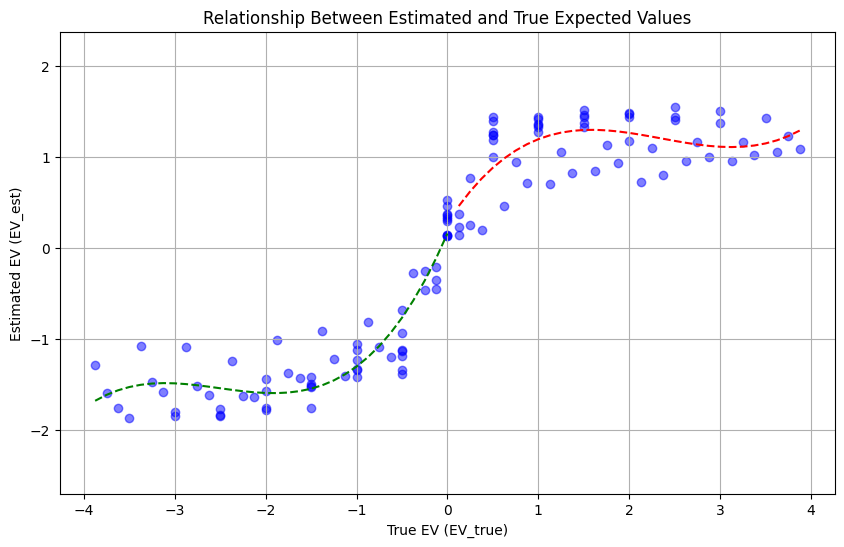

In [117]:
import matplotlib.pyplot as plt

# Assuming your data is stored in a dictionary called 'mean_results'
# mean_results[(gv, bv, pw)] = {'EV_est': calculated_ev, 'EV_true': true_ev}

# Lists to store data for plotting
ev_est = []
ev_true = []

# Extract data from the results dictionary
for key, value in mean_results.items():
    
    ev_est.append(value['EV_est'])
    ev_true.append(value['EV_true'])


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ev_true, ev_est, alpha=0.5, color='blue')
plt.title('Relationship Between Estimated and True Expected Values')
plt.ylabel('Estimated EV (EV_est)')
plt.xlabel('True EV (EV_true)')
plt.grid(True)
plt.axis('equal')  # This ensures that the scale of both axes is the same

# Separate data into above and below zero
above_zero_indices = [i for i, x in enumerate(ev_true) if x > 0]
below_zero_indices = [i for i, x in enumerate(ev_true) if x <= 0]

# Data for above zero
ev_true_above_zero = [ev_true[i] for i in above_zero_indices]
ev_est_above_zero = [ev_est[i] for i in above_zero_indices]

# Fit polynomial for above zero
z_above = np.polyfit(ev_true_above_zero, ev_est_above_zero, 3)
p_above = np.poly1d(z_above)
# Plot as a red dashed line
plt.plot(np.sort(ev_true_above_zero), p_above(np.sort(ev_true_above_zero)), "r--")

# Data for below zero
ev_true_below_zero = [ev_true[i] for i in below_zero_indices]
ev_est_below_zero = [ev_est[i] for i in below_zero_indices]

# Fit polynomial for below zero
z_below = np.polyfit(ev_true_below_zero, ev_est_below_zero, 3)
p_below = np.poly1d(z_below)
# Plot as a green dashed line
plt.plot(np.sort(ev_true_below_zero), p_below(np.sort(ev_true_below_zero)), "g--")

# Show plot
plt.show()


In [42]:
print(results)
parsed_results = {}
for k, v in results.items():
    pos_list = []
    neg_list = []
    for q in query:
        pos_list.append(v[0][q])
        neg_list.append(v[1][q])
    parsed_results[k] = (pos_list)
print(parsed_results)

{(0.2, -0.2, 100): {'a': 7.779080988257192e-07, 'b': 8.83119469108351e-07, 'c': 1.5101024928299012e-06, 'd': 8.66081791173201e-06, 'e': 1, 'f': 0.007281086407601833, 'g': 1.6719615132387844e-06, 'h': 0}, (0.4, -0.2, 100): {'a': 3.093136342613434e-07, 'b': 3.0466631528724974e-07, 'c': 6.976102895350778e-07, 'd': 2.5497283786535263e-06, 'e': 1, 'f': 0.05666691064834595, 'g': 9.832539944909513e-06, 'h': 0}, (0.6, -0.2, 100): {'a': 1.44939562574109e-07, 'c': 3.3815709343798517e-07, 'd': 8.922074812289793e-07, 'e': 0.8779815435409546, 'f': 0.12201842665672302, 'g': 3.957202716264874e-05, 'b': 0, 'h': 0}, (0.8, -0.2, 100): {'a': 1.5307062994907028e-07, 'c': 2.630673350267898e-07, 'd': 5.704771410819376e-07, 'e': 0.7577299475669861, 'f': 0.24227005243301392, 'g': 8.843504474498332e-05, 'b': 0, 'h': 0}, (1, -0.2, 100): {'a': 3.4234955137435463e-07, 'b': 1.7627938575515145e-07, 'c': 2.602484130420635e-07, 'd': 4.553684220809373e-07, 'e': 1, 'f': 0.05061618611216545, 'g': 1.391973637510091e-05, 

KeyError: 0

In [9]:
import csv

filename = 'sensation_no_metaphor.csv'
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['gv', 'bv', 'pw', 'positive', 'negative'])
    for (gv, bv, pw), (pos_list, neg_list) in parsed_results.items():
        pos_string = '[' + ' '.join(str(x) for x in pos_list) + ']'
        neg_string ='[' + ' '.join(str(x) for x in neg_list) + ']'
        writer.writerow([gv, bv, pw, pos_string, neg_string])